***


<div style="position:relative;">
  <div style="position:absolute; z-index:-1;">
    <img src="1_tdNpKocpNtBaPXcOUyfG7A.gif" style="width:100%; height:100%;" />
  </div>
  <br>
<div style="text-align:center">
<font color='white'>
    <h1> <b> Machine Learning 2024 </b> </h1>
    <h2> <i> "Which undersampling models used in combination with SMOTE to resolve class imbalance in lifestyle disease datasets yield the highest prediction accuracy?" </i> </h2>
    <h3> <b> By E. Cohen, M. Voeten, O. Sobol, S. Wang & V. Lanko </b> </h3>
    <h3> Group 92 </h3>
    <h3> <i> Vrije Universiteit Amsterdam </i> </h3>
</font>
</div>
</div>


***

***

<h2>Imports</h2>

***

In [467]:
success = False; attempts = 2
while not success and attempts > 0:
    try:
        # Basic
        import os
        import random
        import warnings
        import collections
        import math
        
        # Data Frames, Graphs
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Machine Learning Libs
        from imblearn.over_sampling import SMOTE
        from sklearn.datasets import make_classification
        from sklearn.model_selection import train_test_split
        from sklearn.svm import SVC
        from sklearn.metrics import accuracy_score
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.ensemble import IsolationForest
        from catboost import CatBoostClassifier
        from imblearn.combine import SMOTEENN
        from imblearn.under_sampling import EditedNearestNeighbours
        from sklearn.model_selection import cross_validate
        from sklearn.exceptions import ConvergenceWarning
        from sklearn.metrics import roc_curve
        from sklearn.metrics import auc
        from crucio import SCUT
        from sklearn.preprocessing import StandardScaler
        from sklearn.preprocessing import MinMaxScaler

        success = True; print("Success")
    except ModuleNotFoundError:
        attempts -= 1
        %pip install -r requirements.txt;
    finally:
        %cd . 
        directory = os.getcwd()
        print([str(directory)])

Success
c:\Users\LalaShops\Desktop\ML Play\ML-92
['c:\\Users\\LalaShops\\Desktop\\ML Play\\ML-92']


In [468]:
# Open the dataset as float32, because memory problems
diabetes_ds = pd.read_csv('diabetes_multiclass.csv', dtype='float32')

GROUP_NR = 92
TEST_MODE = True
TEST_MODE_SAMPLE_SIZE = 3000

***

<h2>Dataset Pre-processing</h2>

***

***

<h3>Task 1: Checking for class imbalance</h3>

***

<h5><b> Target classes: </b></h5>
<p>0: Healthy</p>
<p>1: Prediabetic</p>
<p>2: Diabetic</p>

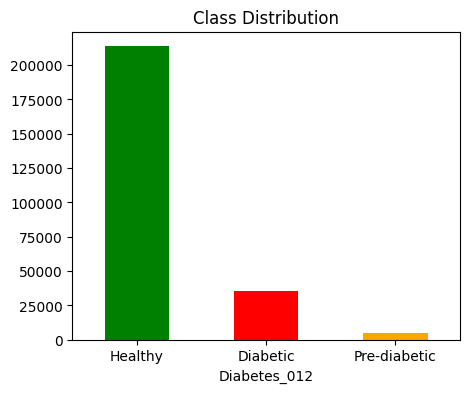


 Percentage per Class: 
 Diabetes_012
0.0    84.241170
2.0    13.933302
1.0     1.825528
Name: count, dtype: float64


In [469]:
class_dist = diabetes_ds["Diabetes_012"].value_counts()
plt.figure(figsize=(5,4))
class_dist.plot(kind="bar", color=["green", "red", "orange"])
plt.xticks(ticks=range(len(class_dist)), labels=["Healthy", "Diabetic", "Pre-diabetic"], rotation=0)
plt.title("Class Distribution")
plt.show()

class_percent = (class_dist/ diabetes_ds.shape[0]) * 100
print("\n Percentage per Class: \n", class_percent)


***

<h3>Task 2: Checking for missing values and labels</h3>

***

In [470]:
#1. check for missing target labels
classes = [0.0, 1.0, 2.0]
missing_labels = [x for x in diabetes_ds["Diabetes_012"] if x not in classes]
print('Number of missing labels: ', missing_labels)

# #2. check for missing target labels
# features = diabetes_ds.drop(columns=['Diabetes_012'])
# missing_values = features.isnull().sum()
# print('Number of missing values: ', missing_labels)

Number of missing labels:  []


***

<h3>Task 3: Checking for Outliers</h3>

***

In [471]:
# Using IsolationForest for anomaly scores and 1.5 * IQR for classifying outliers. 
# IsolationForest isolates a "tree" or data point. Depending on how quickly it is isolated, it receives an anomaly score. Fewer splits = more anomalous.
# The higher the score, the more anomalous. 
# Running in test mode it should remove +-400 outliers.
 
pre = len(diabetes_ds)
isolation_forest = IsolationForest()
isolation_forest.fit(diabetes_ds)
anomaly_scores = isolation_forest.decision_function(diabetes_ds)

Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = [x for x in anomaly_scores if x < lower_bound or x > upper_bound]

outlier_indices = ((anomaly_scores < lower_bound) | (anomaly_scores > upper_bound))

diabetes_ds = diabetes_ds[~outlier_indices]
anomaly_scores = anomaly_scores[~outlier_indices]

print(f"Removed {pre - len(diabetes_ds)} outliers from the dataset")

# ROC Curve better but hard because multiclass. Possible if you treat classes seperately

Removed 569 outliers from the dataset


***

<h3>Task 4: Scale Data</h3>

***

In [472]:
# TODO 

def scale_continuous_features(df):
    # Find continuous features
    continuous_features = df.columns[1:]
    
    if len(continuous_features) == 0:
        print("No continuous features found in the DataFrame.")
        return df
    
    # Scale the continuous features
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[continuous_features] = scaler.fit_transform(df[continuous_features])
    
    return df_scaled

diabetes_ds = scale_continuous_features(diabetes_ds)

diabetes_ds.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.00,0.6,0.5,1.0,0.0,0.666667,0.6,0.285714
1,0.0,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.50,0.0,0.0,0.0,0.0,0.500000,1.0,0.000000
2,0.0,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.00,1.0,1.0,1.0,0.0,0.666667,0.6,1.000000
3,0.0,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.833333,0.4,0.714286
4,0.0,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.1,0.0,0.0,0.0,0.833333,0.8,0.428571


***

<h3> Define Target and Featureset </h3>

***

In [473]:
# Test Mode so you don't have to wait for 10 minutes
if TEST_MODE:
    features = diabetes_ds.sample(TEST_MODE_SAMPLE_SIZE, random_state=GROUP_NR)
    target = features['Diabetes_012']
    features = features.drop(columns=['Diabetes_012'])
else:
    target = diabetes_ds['Diabetes_012']
    features = diabetes_ds.drop(columns=['Diabetes_012'])

***

<h2>Data Overview</h2>

***

In [474]:
# Set number in head to display X amount of rows
features.head(10)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
148883,1.0,0.0,1.0,0.255814,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.50,0.000000,0.466667,1.0,1.0,0.833333,1.0,1.000000
12781,0.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.75,0.000000,0.000000,0.0,0.0,1.000000,1.0,0.857143
251334,0.0,0.0,1.0,0.069767,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,1.000000,0.6,0.142857
231089,0.0,0.0,1.0,0.116279,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.066667,0.000000,0.0,0.0,0.583333,0.8,1.000000
109120,1.0,0.0,1.0,0.267442,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.100000,0.133333,0.0,1.0,0.333333,1.0,0.857143
96336,0.0,0.0,1.0,0.127907,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.100000,0.0,0.0,0.500000,1.0,1.000000
20815,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,1.0,0.0,0.916667,1.0,1.000000
115545,0.0,0.0,1.0,0.081395,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.266667,0.0,0.0,0.416667,0.8,1.000000
101235,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,0.0,0.833333,1.0,0.571429
114597,0.0,1.0,1.0,0.139535,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.166667,0.8,1.000000


In [475]:
# Number of entries per feature
features.info()

nr_features = len(features.columns)
nr_instances = len(features)
print("\nNumber of Features:", nr_features, "\nNumber of Instances:", nr_instances)

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 148883 to 198679
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                3000 non-null   float32
 1   HighChol              3000 non-null   float32
 2   CholCheck             3000 non-null   float32
 3   BMI                   3000 non-null   float32
 4   Smoker                3000 non-null   float32
 5   Stroke                3000 non-null   float32
 6   HeartDiseaseorAttack  3000 non-null   float32
 7   PhysActivity          3000 non-null   float32
 8   Fruits                3000 non-null   float32
 9   Veggies               3000 non-null   float32
 10  HvyAlcoholConsump     3000 non-null   float32
 11  AnyHealthcare         3000 non-null   float32
 12  NoDocbcCost           3000 non-null   float32
 13  GenHlth               3000 non-null   float32
 14  MentHlth              3000 non-null   float32
 15  PhysHlth           

***

<h2>Correlation between Features </h2>

***

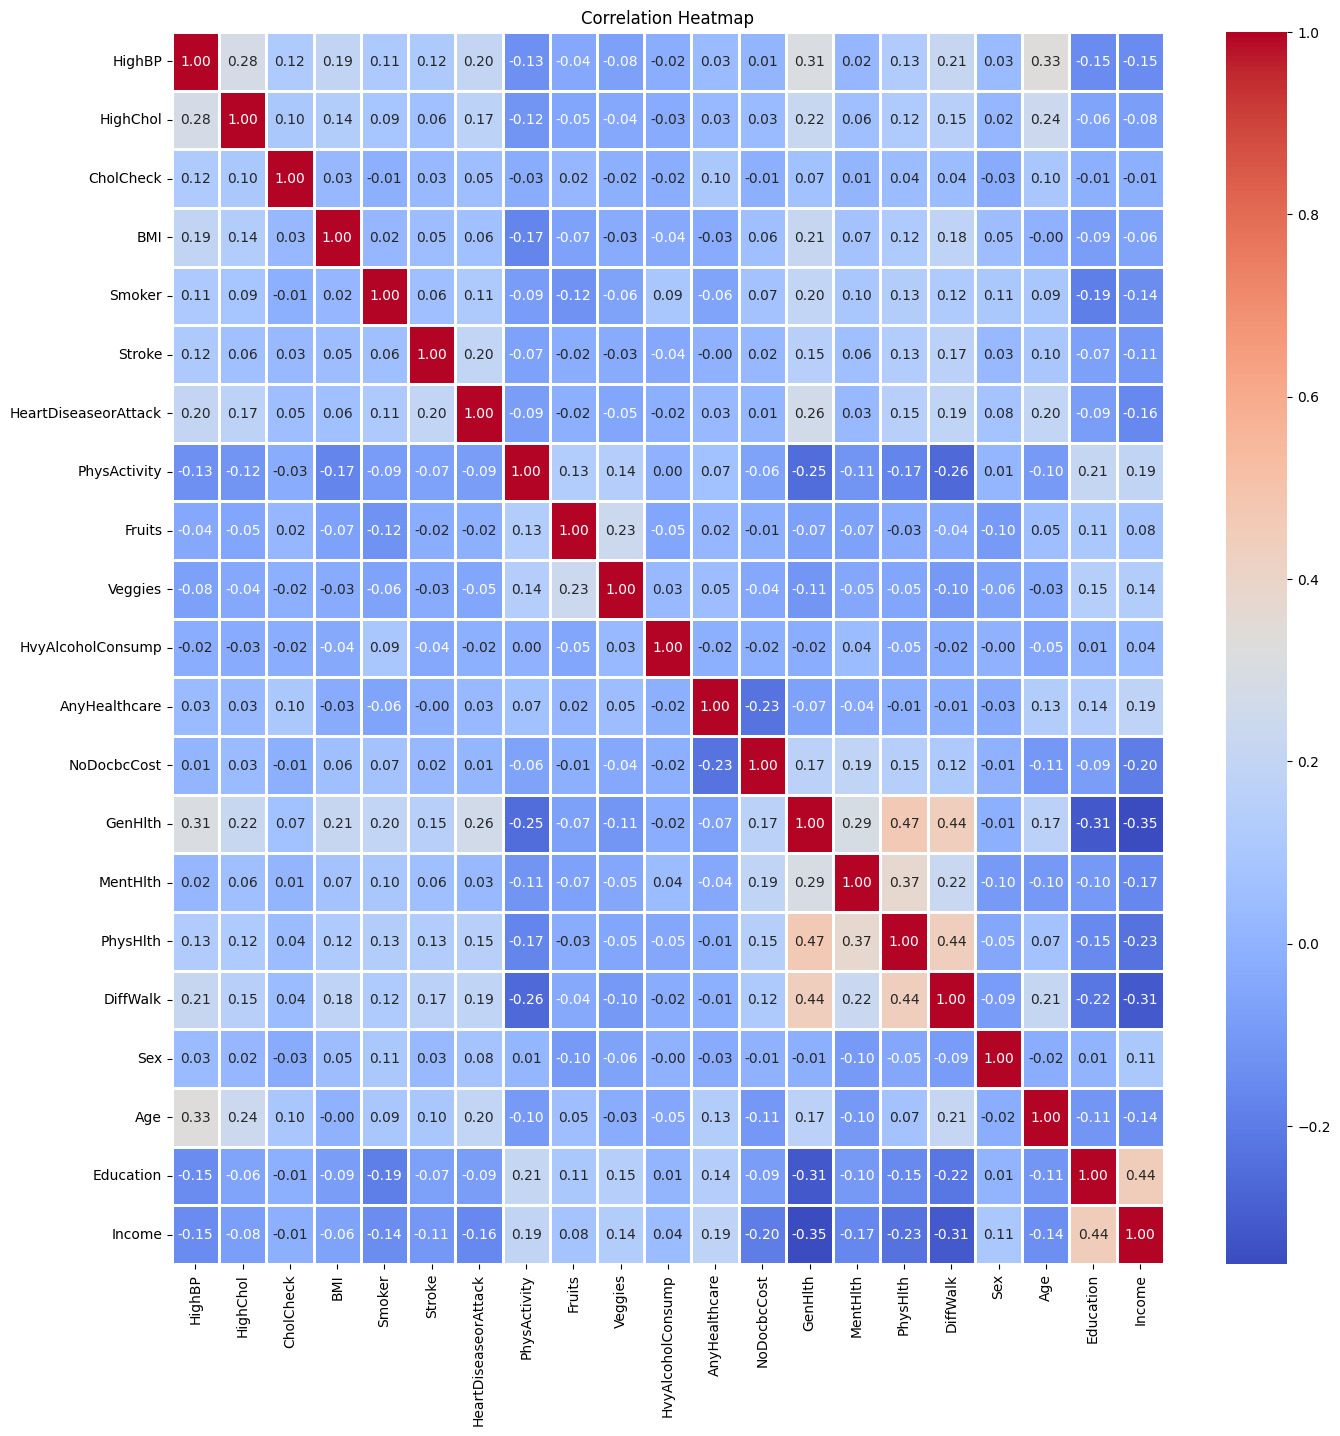

In [476]:
correlation_matrix = features.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

***

<h2>Benchmark</h2>

***

In [477]:
# Benchmark Settings
# Verbose
NEURAL_VERBOSE=True
BENCHMARK_VERBOSE=True

# Neural Network
LEARNING_RATE = 0.005
EPOCHS = 10

# Oversampling
SYNTHETIC_EXAMPLES = 3000


In [478]:
# Neural Network with Backpropagation from Scratch
# TODO: This thing haunts me 
# Followed a YT video to make a neural network with backpropagation. Had to debug it so much to make it work, it probably is more than that. 
# Could probably work, for now it's an expensive way to demonstrate imbalance costs. 

class homemade_NeuralNetwork():
    
    # Initialise the Neural Network. 
    # Uses the "Xavier Initialisation method" for initial weights
    def __init__(self, height, width, learning_rate=0.01, verbose=NEURAL_VERBOSE) -> None:
        self.verbose = verbose
        self.width = width
        self.output = 3
        self.height = height 
        self.learning_rate = learning_rate
        self.weight1 = pd.DataFrame(np.random.randn(self.width, self.height) * math.sqrt(2 / (self.width + self.height)))
        self.weight2 = pd.DataFrame(np.random.randn(self.height, self.output) * math.sqrt(2 / (self.height + self.output)))
        #print("DIMENSIONS", self.width, self.height, self.weight1, self.weight2)
    
    # TODO: replace with SOFTMAX because multi-class suffering. 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Get some output for some example
    def forward_propagation(self, x):
        x = x.reshape(-1, self.width)
        self.layer = pd.DataFrame(np.dot(x, self.weight1))
        self.layer2 = self.sigmoid(self.layer)
        self.layer2_reshaped = self.layer2.values.reshape(-1, self.height)
        self.layer3 = pd.DataFrame(np.dot(self.layer2_reshaped, self.weight2))
        return self.layer3.values.flatten()

    # Backward propagation using gradient descent
    # Uses sigmoid because binary classification. Questionable because we are doing multi-class classification.
    # Should probably use Softmax :S
    def backward_propagation(self, x_input, y_output, output):
        self.output_error = y_output - output
        self.delta = self.output_error * self.sigmoid(output) * (1 - self.sigmoid(output))
        self.layer2_error = self.delta.dot(self.weight2.T)
        self.layer2_delta = self.layer2_error * self.layer2 * (1 - self.layer2)
        self.weight1 += self.learning_rate * x_input.T.dot(self.layer2_delta)
        self.weight2 += self.learning_rate * self.layer2.T.dot(self.delta) 
    
    # Train the model
    # Uses simple average absolute error as loss function
    def fit(self, x_input, y_output, epochs):
        x_input = np.array(x_input).reshape(-1, self.width) 
        y_output = pd.get_dummies(y_output).values
        for i in range(epochs):
            for x, y in zip(x_input, y_output):
                output = self.forward_propagation(x)
                self.backward_propagation(x.reshape(1, -1), y.reshape(1, -1), output)
            if self.verbose: print("Epoch:", i+1, "Loss:", np.mean(np.abs(self.output_error)))    
    
    # Take test data and see if the NN can predict it's label
    # TODO: Stop messing with a mix between Pandas and Numpy and commit to one
    def predict(self, testdata):
        testdata = pd.DataFrame(testdata).values.reshape(-1, self.width)
        predictions = []
        for line in testdata:
            x = np.array(line)
            output_probabilities = self.forward_propagation(x)
            class_label = np.argmax(output_probabilities)
            predictions.append(class_label)
        occ = {x: predictions.count(x) for x in predictions}
        if self.verbose: print("Predictions", predictions, "\nOccurrences:", occ)
        return predictions


# NN = homemade_NeuralNetwork(height, width)
# features_nn = features.reshape(-1, 21)
# print("Shape of features array:", features.shape)
# print("Shape of target array:", target.shape)
# for i in range(30):
#     NN.fit(features_nn, target)

    
# print("Predicted:", str(NN.fordward_propagation(example)))


In [479]:

# TODO: add more metrics besides plain accuracy
# E.g. recall, precision, F1, confusion matrix.

def benchmark_accuracy(features, target, verbose=BENCHMARK_VERBOSE, epochs=5, learning_rate=0.01):
    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=GROUP_NR)
    #print(y_test)
    
    # Get the dimensions for the NN
    rows, cols = x_train.shape
    
    # Initialize models
    logistic_regression = LogisticRegression(solver='saga')
    random_forest = RandomForestClassifier()
    catboost = CatBoostClassifier(logging_level='Silent')
    neural_network = homemade_NeuralNetwork(rows, cols, learning_rate=learning_rate)
 
    # Train models
    # I turned off warnings for convergence during training because they ruined my prints :C
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    logistic_regression.fit(x_train, y_train)
    random_forest.fit(x_train, y_train)
    catboost.fit(x_train, y_train)
    neural_network.fit(x_train, y_train, epochs)
    warnings.filterwarnings("default", category=ConvergenceWarning)
    
    # Make predictions and print them
    lr_predictions = logistic_regression.predict(x_test); lr_score = accuracy_score(y_test, lr_predictions);
    rf_predictions = random_forest.predict(x_test); rf_score = accuracy_score(y_test, rf_predictions);
    cb_predictions = catboost.predict(x_test); cb_score = accuracy_score(y_test, cb_predictions);
    nn_predictions = neural_network.predict(x_test); nn_score = accuracy_score(y_test, nn_predictions);

    # Print Results if desired
    if verbose: print(f"Logistics Regression: {lr_score}\nRandom Forest: {rf_score}\nCatBoost: {cb_score}\nNeural Network: {nn_score}");
    
    return [{"score": lr_score, "prediction": lr_predictions, "y_test": y_test}, \
            {"score": rf_score, "prediction": rf_predictions, "y_test": y_test}, \
            {"score": cb_score, "prediction": cb_predictions, "y_test": y_test}, \
            {"score": nn_score, "prediction": nn_predictions, "y_test": y_test}]

# Counts the occurances of each class in target
def class_imbalance(target):
    unique, counts = np.unique(target, return_counts=True)
    return dict(zip(unique, counts))

def print_bench_results(title, results):
    print(f"{title}\nLogistics Regression: {results[0]['score']}\nRandom Forest: {results[1]['score']}\nCatBoost: {results[2]['score']}\nNeural Network: {results[3]['score']}")


***

<h2>Balancing using only SMOTE</h2>

***

Synthetic Minority Over-Sampling Technique (SMOTE), generates synthetic examples of underrepresented classes in the dataset.

In [480]:
# SMOTE Object
nr_samples = SYNTHETIC_EXAMPLES
nr_of_samples_per_class = {0.0: nr_samples, 1.0: nr_samples, 2.0: nr_samples}

smote = SMOTE(sampling_strategy=nr_of_samples_per_class, random_state=GROUP_NR)

# Print number of instances found before balancing
print(f"Unbalanced {class_imbalance(target)}")

# Actually balance
balanced_features, balanced_diabetes = smote.fit_resample(features, target)

# Print number of instances found after balancing
print(f"Balanced: {class_imbalance(balanced_diabetes)}")

# Print Benchmark results before and after balancing
print("\nUnbalanced")
out_unbalanced = benchmark_accuracy(features, target, epochs=EPOCHS, learning_rate=LEARNING_RATE)

print("\nBalanced with SMOTE")
out_balanced = benchmark_accuracy(balanced_features, balanced_diabetes, epochs=EPOCHS, learning_rate=LEARNING_RATE)

Unbalanced {0.0: 2547, 1.0: 50, 2.0: 403}
Balanced: {0.0: 3000, 1.0: 3000, 2.0: 3000}

Unbalanced


Epoch: 1 Loss: 0.13914217222615624
Epoch: 2 Loss: 0.1313382633798901
Epoch: 3 Loss: 0.12481152530873096
Epoch: 4 Loss: 0.11930511675629064
Epoch: 5 Loss: 0.11462024802961689
Epoch: 6 Loss: 0.11059906830009902
Epoch: 7 Loss: 0.10711499266373344
Epoch: 8 Loss: 0.10406654829759938
Epoch: 9 Loss: 0.10137280520253655
Epoch: 10 Loss: 0.09896960664366367
Predictions [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

***

<h2>Balancing using SMOTE + ENN</h2>

***

Link: [SMOTE + ENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)

In [481]:
# SMOTE Object
nr_samples = SYNTHETIC_EXAMPLES
nr_of_samples_per_class = {0.0: nr_samples, 1.0: nr_samples, 2.0: nr_samples}

smote = SMOTEENN(sampling_strategy=nr_of_samples_per_class, random_state=GROUP_NR)

# Print number of instances found before balancing
print(f"Unbalanced {class_imbalance(target)}")

# Actually balance
balanced_features, balanced_diabetes = smote.fit_resample(features, target)

# Print number of instances found after balancing
print(f"Balanced: {class_imbalance(balanced_diabetes)}")

# Print Benchmark results before and after balancing
print_bench_results("Unbalanced Accuracy", out_unbalanced)

# Print Benchmark results before and after balancing
print_bench_results("\nSMOTE Balanced Accuracy", out_balanced)

print("\nBalanced with SMOTE + ENN")
out_balanced = benchmark_accuracy(balanced_features, balanced_diabetes, epochs=EPOCHS, learning_rate=LEARNING_RATE)

Unbalanced {0.0: 2547, 1.0: 50, 2.0: 403}


Balanced: {0.0: 2061, 1.0: 2993, 2.0: 2760}
Unbalanced Accuracy
Logistics Regression: 0.8483333333333334
Random Forest: 0.8666666666666667
CatBoost: 0.8633333333333333
Neural Network: 0.8616666666666667

SMOTE Balanced Accuracy
Logistics Regression: 0.6233333333333333
Random Forest: 0.9555555555555556
CatBoost: 0.9427777777777778
Neural Network: 0.49

Balanced with SMOTE + ENN
Epoch: 1 Loss: 0.26619919142982645
Epoch: 2 Loss: 0.2781257422985656
Epoch: 3 Loss: 0.30656588196033346
Epoch: 4 Loss: 0.3383608374019727
Epoch: 5 Loss: 0.35512602068572535
Epoch: 6 Loss: 0.36520183025459224
Epoch: 7 Loss: 0.37178114566982173
Epoch: 8 Loss: 0.3762069427196564
Epoch: 9 Loss: 0.3791456843131648
Epoch: 10 Loss: 0.3809905235412881
Predictions [1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 

In [482]:
print(out_balanced[3])

{'score': 0.4779270633397313, 'prediction': [1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

***

<h2>Balancing using SCUT</h2>

***

Balancing using SCUT (SMOTE + Clustering)


<h3> SMOTE Function

In [483]:
# Smote algorithm:
# Identify data point from minority class
# Find k nearest neighbour
# Create data point between point and neighbour
# repeat

class homemade_SMOTE():
    def __init__(self, labels, dataframe, kneighbours, N_examples, label) -> None:
        self.labels = labels
        self.label = label
        self.label_count = self.count_occurrences()
        self.dataframe = dataframe
        self.kneighbours = kneighbours
        self.N_examples = N_examples
        self.data_by_cat = self.get_data_by_label()
        self.class_labels = self.gather_samples(self.label)
        self.features = self.dataframe.columns.tolist()
    
    def count_occurrences(self):
        output = dict()
        for x in self.labels: output[x] = output.get(x, 0) + 1;
        return output
    
    def get_data_by_label(self):
        merged_ds = pd.merge(self.labels, self.dataframe, left_index=True, right_index=True)
        grouped_by_label = merged_ds.groupby(self.label)
        return grouped_by_label
    
    def gather_samples(self, label="Diabetes_012"):
        output = dict(); unique_entries = list(); full_list = list()
        for label, group in self.data_by_cat[label]:
            unique_entries.append(label)
            for _, row in group.items():
                output[label] = output.get(label, []) + [row]; full_list.append(row)
        return (full_list, output, unique_entries)
        
    def smote_continuous(self):
        pass

    def smote_ordinal(self):
        pass

    def smote_binary(self):
        pass

    def smote_get_minority_class(labels, minority_class_label):
        pass
    
    def get_workload(self, N):
        workload = dict()
        for key, value in N.items(): workload[key] = (value - self.label_count[key]) if self.label_count[key] < value else 0
        return workload

    def smote(self, N: dict):
        # Synthetics
        synthetic = dict()
        # How many Examples do we have to make of each label?
        workload = self.get_workload(N)
        for key, item in workload.items():
            for feature in self.features:
                print(feature, self.gather_samples(label=feature)[1][2.0])
        
        # Convert to Panda
        synthetic_df = pd.DataFrame(synthetic)
        
    def combine_smote(self):
        pass



    
    

home_smote = homemade_SMOTE(target, features, 2, 10000, "Diabetes_012")
home_smote.smote({0.0: 15000, 1.0: 15000, 2.0: 15000})


HighBP [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.

PhysActivity [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1

<h3>Expectation Maximization

<h3>Oversampling

<h3>Undersampling

***

<h2>Balancing using SMOTE + ....????</h2>

***